In [1]:
import pandas as pd

### Data Collection

In [2]:
import requests

# URLs of the files
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv'

# Function to download a file
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()  # Ensure we notice bad responses
    with open(file_name, 'wb') as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# Downloading the files
download_file(train_data_url, 'module3_exercise_train.csv')
download_file(test_data_url, 'module3_exercise_test.csv')

Downloaded module3_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv
Downloaded module3_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv


In [7]:
df_train =  pd.read_csv("module3_exercise_train.csv", sep=",", index_col='id')
df_test = pd.read_csv("module3_exercise_test.csv", sep=",", index_col='id')
print("训练数据形状:", df_train.shape)
print("测试数据形状:", df_test.shape)

训练数据形状: (1168, 17)
测试数据形状: (292, 16)


### Data analysis

Downloaded module3_exercise_train.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv
Downloaded module3_exercise_test.csv from https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv
Training data shape: (1168, 17)
Test data shape: (292, 16)

=== Processing English Words to Arabic Numbers ===

=== Basic Data Information ===
First 5 rows of training data:
      BedroomAbvGr  KitchenAbvGr  TotRmsAbvGrd  Fireplaces  GarageYrBlt  \
id                                                                        
254              2             1           4.0           1       1977.0   
1066             1             1           5.0           1       1983.0   
638              4             1          10.0           1       1998.0   
799              3             1           8.0           0       1916.0   
380              2             1           5.0           0       2005.0   

     Gar

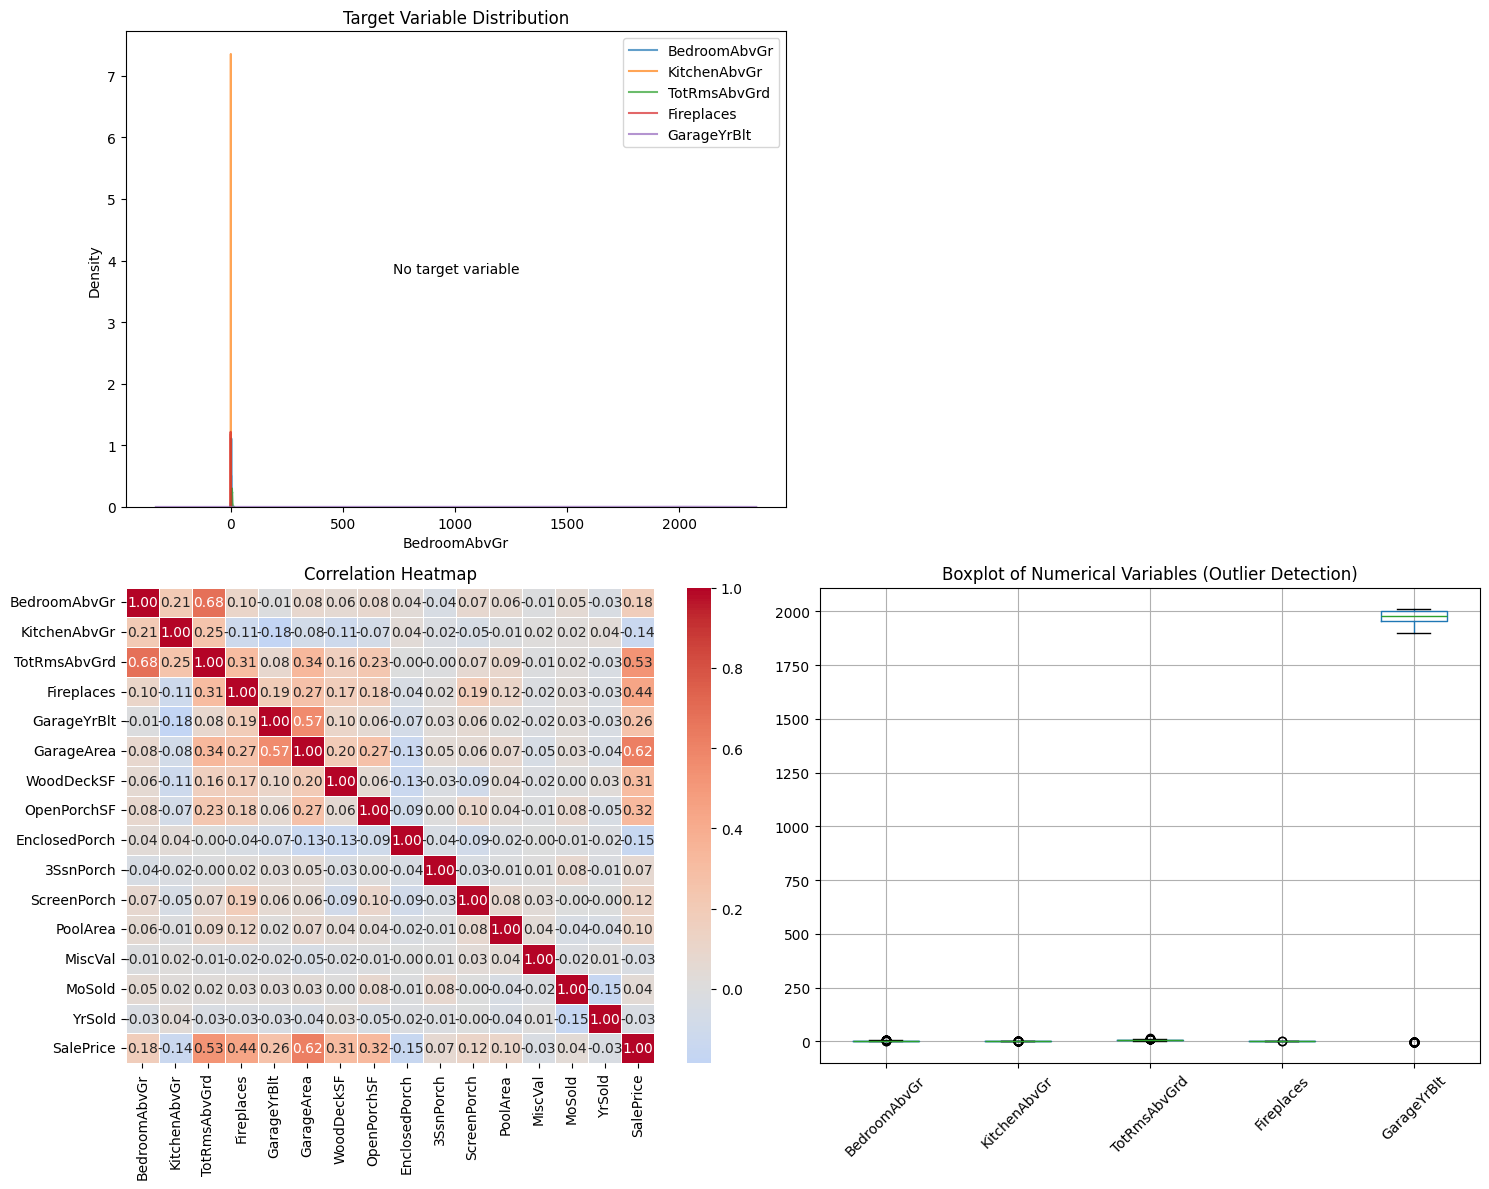


=== Categorical Variables Analysis ===

Value distribution for GarageCars:
GarageCars
two      662
one      298
three    140
zero      65
four       2
Name: count, dtype: int64


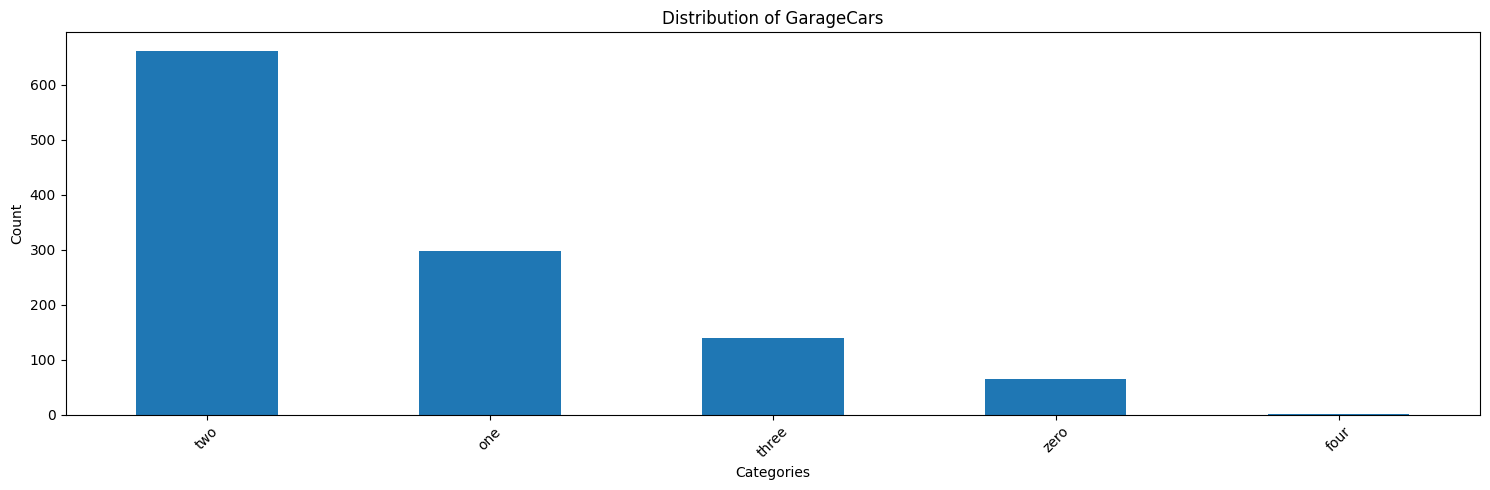


=== Data Quality Report ===
Total samples: 1168
Total features: 17
Numerical features: 16
Categorical features: 1

=== Outlier Detection ===
BedroomAbvGr: 26 outliers (2.23%)
KitchenAbvGr: 49 outliers (4.20%)
TotRmsAbvGrd: 25 outliers (2.14%)
Fireplaces: 2 outliers (0.17%)
GarageYrBlt: 65 outliers (5.57%)
GarageArea: 14 outliers (1.20%)
WoodDeckSF: 25 outliers (2.14%)
OpenPorchSF: 71 outliers (6.08%)
EnclosedPorch: 179 outliers (15.33%)
3SsnPorch: 18 outliers (1.54%)
ScreenPorch: 95 outliers (8.13%)
PoolArea: 5 outliers (0.43%)
MiscVal: 42 outliers (3.60%)
MoSold: 0 outliers (0.00%)
YrSold: 0 outliers (0.00%)
SalePrice: 49 outliers (4.20%)


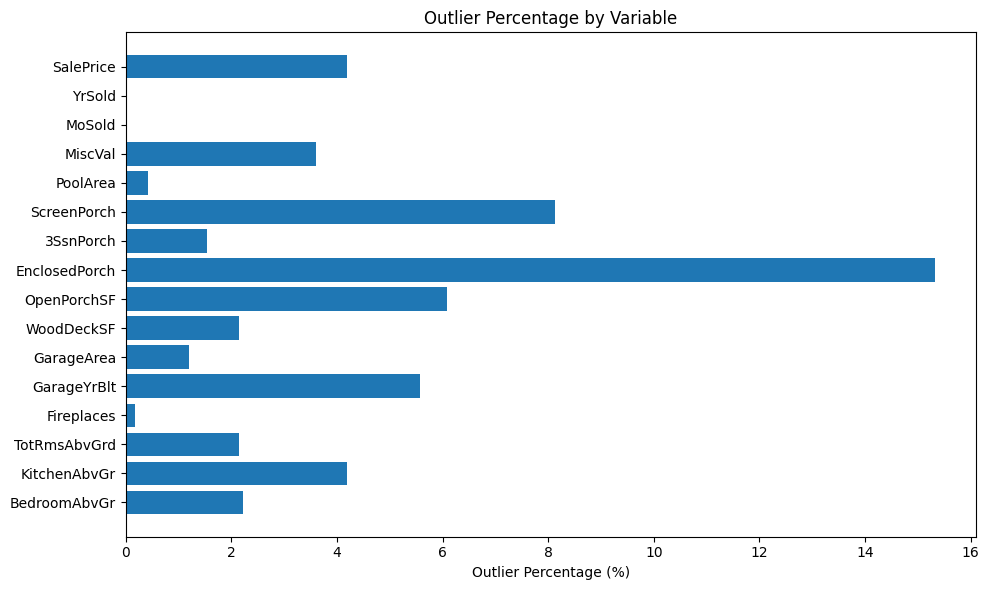


Data analysis completed! Based on the above analysis, you can proceed with feature engineering and model building.
Processed data saved as CSV files


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, classification_report, confusion_matrix
import requests
import warnings
warnings.filterwarnings('ignore')

# 设置中文显示（用于可能的文本内容）
plt.rcParams['font.sans-serif'] = ['SimHei', 'Microsoft YaHei', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False

# 修正下载函数和文件读取
def download_file(url, file_name):
    response = requests.get(url)
    response.raise_for_status()
    with open(file_name, "wb") as file:
        file.write(response.content)
    print(f'Downloaded {file_name} from {url}')

# 下载文件
train_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_train.csv'
test_data_url = 'https://www.raphaelcousin.com/modules/data-science-practice/module3/exercise/module3_exercise_test.csv'

download_file(train_data_url, 'module3_exercise_train.csv')
download_file(test_data_url, 'module3_exercise_test.csv')

# 修正读取代码
df_train = pd.read_csv("module3_exercise_train.csv", sep=",", index_col='id')
df_test = pd.read_csv("module3_exercise_test.csv", sep=",", index_col='id')

print("Training data shape:", df_train.shape)
print("Test data shape:", df_test.shape)

# 英语单词转阿拉伯数字的函数
def convert_word_to_number(word):
    """
    将英语单词转换为阿拉伯数字
    """
    if pd.isna(word):
        return word

    word_str = str(word).lower().strip()

    # 定义映射字典
    number_mapping = {
        'zero': '0', 'one': '1', 'two': '2', 'three': '3', 'four': '4',
        'five': '5', 'six': '6', 'seven': '7', 'eight': '8', 'nine': '9',
        'ten': '10', 'eleven': '11', 'twelve': '12',
        'none': '0', 'no': '0', 'zero cars': '0'
    }

    # 尝试映射
    if word_str in number_mapping:
        return number_mapping[word_str]

    # 如果已经是数字，直接返回
    try:
        float(word_str)
        return word_str
    except ValueError:
        pass

    return word  # 无法转换，返回原值

def process_word_columns(df, word_columns=None):
    """
    处理包含英语单词的列，将其转换为阿拉伯数字
    """
    if word_columns is None:
        # 自动检测可能包含英语数字的列
        word_columns = []
        for col in df.columns:
            # 检查列中是否包含常见的英语数字单词
            sample_values = df[col].dropna().astype(str).str.lower().unique()
            english_numbers = ['zero', 'one', 'two', 'three', 'four', 'five',
                             'six', 'seven', 'eight', 'nine', 'ten']
            if any(any(word in str(val) for word in english_numbers) for val in sample_values[:10]):
                word_columns.append(col)

    for col in word_columns:
        if col in df.columns:
            print(f"Processing column: {col}")
            print(f"Before conversion unique values: {df[col].unique()}")

            # 应用转换
            df[col] = df[col].apply(convert_word_to_number)

            print(f"After conversion unique values: {df[col].unique()}")
            print("-" * 50)

    return df

# 应用英语单词转换（特别处理garagecars列）
print("\n=== Processing English Words to Arabic Numbers ===")

# 明确指定要处理的列（包括garagecars）
columns_to_convert = ['garagecars']  # 可以添加其他列名

# 处理训练集
df_train = process_word_columns(df_train, columns_to_convert)

# 处理测试集
df_test = process_word_columns(df_test, columns_to_convert)


# Data Exploration Analysis
print("\n=== Basic Data Information ===")
print("First 5 rows of training data:")
print(df_train.head())

print("\nTraining data info:")
print(df_train.info())

print("\nDescriptive statistics:")
print(df_train.describe())

print("\nMissing values summary:")
print(df_train.isnull().sum())

# Data Visualization Analysis
plt.figure(figsize=(15, 12))

# 1. Distribution of numerical variables
numerical_cols = df_train.select_dtypes(include=[np.number]).columns.tolist()
if 'target' in numerical_cols:
    numerical_cols.remove('target')

n_numerical = len(numerical_cols)

plt.subplot(2, 2, 1)
if n_numerical > 0:
    for col in numerical_cols[:min(5, len(numerical_cols))]:
        sns.kdeplot(df_train[col], label=col, alpha=0.7)
    plt.title('Distribution of Numerical Variables')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No numerical variables', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Distribution of Numerical Variables')

# 2. Target variable analysis (if exists)
if 'target' in df_train.columns:
    plt.subplot(2, 2, 2)
    if df_train['target'].dtype == 'object' or df_train['target'].nunique() < 10:
        # Categorical target variable
        df_train['target'].value_counts().plot(kind='bar')
        plt.title('Target Variable Distribution (Classification)')
        plt.xlabel('Categories')
        plt.ylabel('Count')
    else:
        # Numerical target variable
        sns.histplot(df_train['target'], kde=True)
        plt.title('Target Variable Distribution (Regression)')
        plt.xlabel('Target Values')
        plt.ylabel('Frequency')
else:
    plt.text(0.5, 0.5, 'No target variable', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Target Variable Distribution')

# 3. Correlation heatmap
plt.subplot(2, 2, 3)
numeric_df = df_train.select_dtypes(include=[np.number])
if len(numeric_df.columns) > 1:
    correlation_matrix = numeric_df.corr()
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0,
                fmt='.2f', linewidths=0.5)
    plt.title('Correlation Heatmap')
else:
    plt.text(0.5, 0.5, 'Insufficient numerical variables\nfor correlation analysis',
             ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Correlation Heatmap')

# 4. Boxplot for outlier detection
plt.subplot(2, 2, 4)
if len(numerical_cols) > 0:
    df_train[numerical_cols[:min(5, len(numerical_cols))]].boxplot()
    plt.title('Boxplot of Numerical Variables (Outlier Detection)')
    plt.xticks(rotation=45)
else:
    plt.text(0.5, 0.5, 'No numerical variables', ha='center', va='center', transform=plt.gca().transAxes)
    plt.title('Boxplot of Numerical Variables')

plt.tight_layout()
plt.show()

# Categorical variables analysis (if exist)
categorical_cols = df_train.select_dtypes(include=['object']).columns.tolist()
if categorical_cols:
    print("\n=== Categorical Variables Analysis ===")
    for col in categorical_cols:
        print(f"\nValue distribution for {col}:")
        print(df_train[col].value_counts())

    # Categorical variables visualization
    n_categorical = len(categorical_cols)
    if n_categorical > 0:
        fig, axes = plt.subplots(1, min(3, n_categorical), figsize=(15, 5))
        if n_categorical == 1:
            axes = [axes]
        elif n_categorical == 0:
            axes = []

        for i, col in enumerate(categorical_cols[:3]):
            if i < len(axes):
                value_counts = df_train[col].value_counts()
                # Show only top 10 categories if too many
                if len(value_counts) > 10:
                    value_counts = value_counts.head(10)
                    axes[i].set_title(f'Distribution of {col} (Top 10)')
                else:
                    axes[i].set_title(f'Distribution of {col}')

                value_counts.plot(kind='bar', ax=axes[i])
                axes[i].set_xlabel('Categories')
                axes[i].set_ylabel('Count')
                axes[i].tick_params(axis='x', rotation=45)

        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

# Relationship analysis between variables and target (if target exists)
if 'target' in df_train.columns:
    print("\n=== Relationship Analysis with Target Variable ===")

    # Numerical variables vs target
    if df_train['target'].dtype in ['int64', 'float64'] and df_train['target'].nunique() > 10:
        # Numerical target - scatter plots
        fig, axes = plt.subplots(2, 3, figsize=(15, 10))
        axes = axes.ravel()

        for i, col in enumerate(numerical_cols[:min(6, len(numerical_cols))]):
            axes[i].scatter(df_train[col], df_train['target'], alpha=0.5)
            axes[i].set_xlabel(col)
            axes[i].set_ylabel('Target Variable')
            axes[i].set_title(f'{col} vs Target')

        # Hide empty subplots
        for j in range(i+1, len(axes)):
            axes[j].set_visible(False)

        plt.tight_layout()
        plt.show()

    elif df_train['target'].dtype == 'object' or df_train['target'].nunique() <= 10:
        # Categorical target - grouped analysis
        if len(numerical_cols) > 0:
            fig, axes = plt.subplots(2, 2, figsize=(15, 10))
            axes = axes.ravel()

            # Boxplot of numerical variables grouped by target
            for i, col in enumerate(numerical_cols[:min(4, len(numerical_cols))]):
                df_train.boxplot(column=col, by='target', ax=axes[i])
                axes[i].set_title(f'{col} by Target')
                axes[i].set_xlabel('Target Variable')
                axes[i].set_ylabel(col)

            # Hide empty subplots
            for j in range(i+1, len(axes)):
                axes[j].set_visible(False)

            plt.suptitle('')  # Remove auto-generated title
            plt.tight_layout()
            plt.show()

# Data Quality Report
print("\n=== Data Quality Report ===")
print(f"Total samples: {len(df_train)}")
print(f"Total features: {len(df_train.columns)}")
print(f"Numerical features: {len(numerical_cols)}")
print(f"Categorical features: {len(categorical_cols)}")

if 'target' in df_train.columns:
    print(f"Target variable type: {df_train['target'].dtype}")
    if df_train['target'].dtype == 'object' or df_train['target'].nunique() <= 10:
        print("Problem type: Classification")
        print("Class distribution:")
        target_counts = df_train['target'].value_counts()
        for value, count in target_counts.items():
            percentage = count / len(df_train) * 100
            print(f"  {value}: {count} samples ({percentage:.2f}%)")
    else:
        print("Problem type: Regression")
        print(f"Target range: {df_train['target'].min():.2f} - {df_train['target'].max():.2f}")
        print(f"Target mean: {df_train['target'].mean():.2f}")
        print(f"Target std: {df_train['target'].std():.2f}")

# Outlier Detection
print("\n=== Outlier Detection ===")
if len(numerical_cols) > 0:
    outlier_summary = []
    for col in numerical_cols:
        Q1 = df_train[col].quantile(0.25)
        Q3 = df_train[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df_train[(df_train[col] < lower_bound) | (df_train[col] > upper_bound)]
        outlier_percentage = len(outliers) / len(df_train) * 100
        outlier_summary.append((col, len(outliers), outlier_percentage))
        print(f"{col}: {len(outliers)} outliers ({outlier_percentage:.2f}%)")

    # Outlier visualization
    if outlier_summary:
        outlier_df = pd.DataFrame(outlier_summary, columns=['Variable', 'Outlier Count', 'Outlier Percentage'])
        plt.figure(figsize=(10, 6))
        plt.barh(outlier_df['Variable'], outlier_df['Outlier Percentage'])
        plt.xlabel('Outlier Percentage (%)')
        plt.title('Outlier Percentage by Variable')
        plt.tight_layout()
        plt.show()
else:
    print("No numerical variables for outlier detection")

print("\nData analysis completed! Based on the above analysis, you can proceed with feature engineering and model building.")

# Save processed data (optional)
df_train.to_csv('processed_train_data.csv', encoding='utf-8')
df_test.to_csv('processed_test_data.csv', encoding='utf-8')
print("Processed data saved as CSV files")